# Try Fastai

Fastai provides an API for semantic segmentation. The first attempt is to learn how to use it.

In [1]:
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image

from pathlib import Path
import os
import random

from fastai.callbacks.hooks import *
from fastai.utils.mem import *

import random

## Preparation

Main challenge with fastai is the creation of databunch. After that its all straightforward.

In [2]:
PROJ_DIR = Path(os.path.abspath("")).parent
PROJ_DIR

PosixPath('/home/pankaj/Pankaj/Learning/Kaggle/cloud')

In [3]:
path_train_img = PROJ_DIR / "data" / "raw" / "train_images"
path_train_labels = PROJ_DIR / "data" / "raw" / "train_labels"
path_test_img = PROJ_DIR / "data" / "raw" / "test_images"

In [4]:
fnames = get_image_files(path_train_img)
fnames[:3]

[PosixPath('/home/pankaj/Pankaj/Learning/Kaggle/cloud/data/raw/train_images/6550e47.jpg'),
 PosixPath('/home/pankaj/Pankaj/Learning/Kaggle/cloud/data/raw/train_images/ade61a0.jpg'),
 PosixPath('/home/pankaj/Pankaj/Learning/Kaggle/cloud/data/raw/train_images/cc841a2.jpg')]

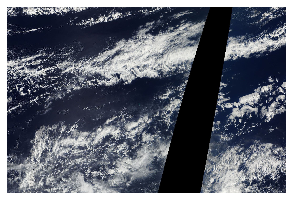

In [5]:
img_f = random.choice(fnames)
img = open_image(img_f)
img.show(figsize=(5, 5))

In [6]:
get_y_fn = lambda x: path_train_labels / f"{x.stem}.png"

In [7]:
img_f

PosixPath('/home/pankaj/Pankaj/Learning/Kaggle/cloud/data/raw/train_images/85eabc1.jpg')

In [8]:
get_y_fn(img_f)

PosixPath('/home/pankaj/Pankaj/Learning/Kaggle/cloud/data/raw/train_labels/85eabc1.png')

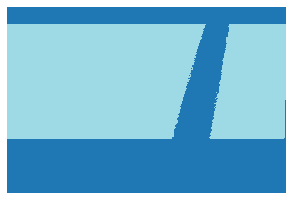

In [9]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5, 5), alpha=1)

### Reading Labels

In [10]:
codes = np.array(["Void", "Fish", "Flower", "Gravel", "Sugar"])
codes

array(['Void', 'Fish', 'Flower', 'Gravel', 'Sugar'], dtype='<U6')

In [11]:
np.unique(mask.data)

array([  0, 253, 254, 255])

## Create DataBunch

In [12]:
free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200:
    bs = 8
else:
    bs = 4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=4, have 5539MB of GPU RAM free


In [13]:
src_size = np.array(img.shape[1:])
src_size

array([1400, 2100])

In [14]:
size = src_size // 4
bs =2 
size

array([350, 525])

In [15]:
name2id = {v: k for k, v in enumerate(codes)}
void_code = name2id["Void"]


def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask] == target[mask]).float().mean()

In [16]:
metrics = acc_camvid

In [17]:
a = SegmentationItemList.from_folder(path_train_img)
a

SegmentationItemList (5546 items)
Image (3, 1400, 2100),Image (3, 1400, 2100),Image (3, 1400, 2100),Image (3, 1400, 2100),Image (3, 1400, 2100)
Path: /home/pankaj/Pankaj/Learning/Kaggle/cloud/data/raw/train_images

In [18]:
a.label_from_func??

In [19]:
src = (SegmentationItemList.from_folder(path_train_img)
       .split_by_rand_pct()
       .label_from_func(get_y_fn, classes=codes))
src

LabelLists;

Train: LabelList (4437 items)
x: SegmentationItemList
Image (3, 1400, 2100),Image (3, 1400, 2100),Image (3, 1400, 2100),Image (3, 1400, 2100),Image (3, 1400, 2100)
y: SegmentationLabelList
ImageSegment (1, 1400, 2100),ImageSegment (1, 1400, 2100),ImageSegment (1, 1400, 2100),ImageSegment (1, 1400, 2100),ImageSegment (1, 1400, 2100)
Path: /home/pankaj/Pankaj/Learning/Kaggle/cloud/data/raw/train_images;

Valid: LabelList (1109 items)
x: SegmentationItemList
Image (3, 1400, 2100),Image (3, 1400, 2100),Image (3, 1400, 2100),Image (3, 1400, 2100),Image (3, 1400, 2100)
y: SegmentationLabelList
ImageSegment (1, 1400, 2100),ImageSegment (1, 1400, 2100),ImageSegment (1, 1400, 2100),ImageSegment (1, 1400, 2100),ImageSegment (1, 1400, 2100)
Path: /home/pankaj/Pankaj/Learning/Kaggle/cloud/data/raw/train_images;

Test: None

In [20]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))
data

ImageDataBunch;

Train: LabelList (4437 items)
x: SegmentationItemList
Image (3, 350, 525),Image (3, 350, 525),Image (3, 350, 525),Image (3, 350, 525),Image (3, 350, 525)
y: SegmentationLabelList
ImageSegment (1, 350, 525),ImageSegment (1, 350, 525),ImageSegment (1, 350, 525),ImageSegment (1, 350, 525),ImageSegment (1, 350, 525)
Path: /home/pankaj/Pankaj/Learning/Kaggle/cloud/data/raw/train_images;

Valid: LabelList (1109 items)
x: SegmentationItemList
Image (3, 350, 525),Image (3, 350, 525),Image (3, 350, 525),Image (3, 350, 525),Image (3, 350, 525)
y: SegmentationLabelList
ImageSegment (1, 350, 525),ImageSegment (1, 350, 525),ImageSegment (1, 350, 525),ImageSegment (1, 350, 525),ImageSegment (1, 350, 525)
Path: /home/pankaj/Pankaj/Learning/Kaggle/cloud/data/raw/train_images;

Test: None

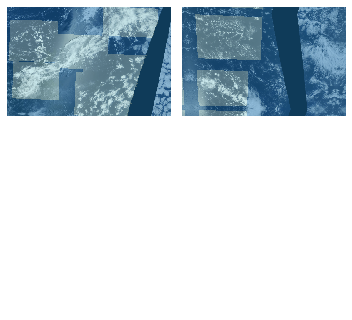

In [22]:
data.show_batch(2, figsize=(5,5))

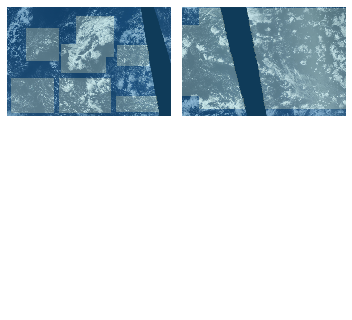

In [23]:
data.show_batch(2, figsize=(5, 5), ds_type=DatasetType.Valid)

In [24]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [25]:
metrics = acc_camvid

In [26]:
wd=1e-2

In [27]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [ ]:
lr_find(learn)

epoch,train_loss,valid_loss,acc_camvid,time


In [ ]:
learn.recorder.plot()

In [ ]:
bs=2

In [ ]:
# Did not work because of transformations
data = (
    SegmentationItemList.from_folder(path_train_img)
    .split_by_rand_pct()
    .label_from_func(get_y_fn, classes=codes)
    .transform(get_transforms(), size=size, tfm_y=True)
    .databunch(bs=bs)
    .normalize(imagenet_stats)
)

data

In [ ]:
# RuntimeError: [enforce fail at ..\c10\core\CPUAllocator.cpp:62] data. DefaultCPUAllocator: not enough memory: you tried to allocate %dGB. Buy new RAM!9
data = (
    SegmentationItemList.from_folder(path_train_img)
    .split_by_rand_pct()
    .label_from_func(get_y_fn, classes=codes)
    .add_test_folder(path_test_img)
    .databunch(bs=bs)
    .normalize(imagenet_stats)
)

data

In [ ]:
# Did not work because of transformations
data = (
    SegmentationItemList.from_folder(path_train_img)
    .split_by_rand_pct()
    .label_from_func(get_y_fn, classes=codes)
    .transform(get_transforms(), size=size, tfm_y=True)
    .databunch(bs=bs)
    .normalize(imagenet_stats)
)

data

In [ ]:
wd = 1e-2
# bs=1

In [ ]:
learn = unet_learner(data, models.resnet18, wd=wd)

In [ ]:
learn

In [ ]:
lr_find(learn)

In [ ]:
learn.recorder.plot()